In [2]:
import itertools
import sklearn
import pandas as pd
import json
import numpy as np
import ast
from tqdm.auto import tqdm
import statistics
import math
import csv
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import NearestCentroid
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.calibration import calibration_curve
from copy import deepcopy
import pprint
import ast
import statistics
import math
import time
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    mean_squared_error,
    r2_score,
    roc_auc_score,
    average_precision_score,
)
import matplotlib.pyplot as plt
from nltk import agreement
import scipy.stats as stats
import seaborn as sns
np.random.seed(1)

In [8]:
df_embeddings_2017.shape[0]

490

In [24]:
embedding_path = '../data/raw/df_embeddings.csv'
submission_path = '../data/raw/df_submission_rating.csv'


aggl_cluster_distance = [0.04,0.07,0.1,0.13,0.16]
input_data = []

for agg_dist in tqdm(aggl_cluster_distance):
    df_embeddings = pd.read_csv(embedding_path)
    df_embeddings = df_embeddings.T
    df_embeddings.columns=df_embeddings.iloc[0]
    df_embeddings = df_embeddings.iloc[1: , :]


    tqdm.pandas()
    def get_numpy (row):
      return ast.literal_eval(row.embedding)

    df_embeddings['embedding'] = df_embeddings.apply(lambda x: get_numpy(x), axis =1)

    df_submissions = pd.read_csv(submission_path)
    df_submission_labels = df_submissions[['id','title','conf_year','keywords','AVG_rating']]

    df_embeddings_2017 = df_embeddings.merge(df_submission_labels[df_submission_labels['conf_year']==2017], left_on='paper_id',right_on='id')
    df_embeddings_2018 = df_embeddings.merge(df_submission_labels[df_submission_labels['conf_year']==2018], left_on='paper_id',right_on='id')
    assert df_submission_labels[df_submission_labels['conf_year']==2017].shape[0] == df_embeddings_2017.shape[0]

    #Section 3.3 Step 2 agglomerative clustering on cosine distance
    x = np.array(df_embeddings_2017.embedding.tolist())
    clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=agg_dist, linkage="average", metric = 'cosine').fit(x)
    df_embeddings_2017['agg_cluster'] = clustering.labels_.tolist()
    agglo_cluster_number = clustering.n_clusters_

    KNN = [5,10,15,20,25,30]
    #Tune KNN matching based on smallest possible cosine distance
    for number_neighbors in KNN:
        input_row = {}
        tuning_param_knn = number_neighbors
        tuning_param_cos_dist = 0.234535

        neigh = NearestNeighbors( n_neighbors=tuning_param_knn, metric = 'cosine', radius = 0.3)
        non_anchor_embedding_2018 = np.array(df_embeddings_2018.embedding.to_list())
        neigh.fit(non_anchor_embedding_2018)

        #setting up closest centroid for anchor group 2017
        anchor_embedding_2017 = np.array(df_embeddings_2017.embedding.tolist())
        anchor_agg_clusters_2017 = np.array(df_embeddings_2017.agg_cluster.tolist())
        clf = NearestCentroid()
        clf.fit(anchor_embedding_2017, anchor_agg_clusters_2017)


        #dictionary of all the agg clusters and the 20 KNN from 2018
        dict_agg_cluster_matches ={}
        for cluster_id in np.unique(clustering.labels_):

            distances, indices = neigh.kneighbors([clf.centroids_[cluster_id]])
            df_anchor_embedding = pd.concat([pd.DataFrame(data = distances.T,columns =['cos_dist']),pd.DataFrame(indices.T,columns=['indices'])],axis=1)

            #get all the specified cosine distance 2018 papers
            #tuple of (dataframe of 2018 matched papers, cosine distances)
            dict_agg_cluster_matches[cluster_id] = (
                df_embeddings_2018.iloc[df_anchor_embedding[df_anchor_embedding['cos_dist']<= tuning_param_cos_dist].indices.to_list(), :],
                df_anchor_embedding[df_anchor_embedding['cos_dist']<= tuning_param_cos_dist].cos_dist.to_list()
            )

        def lambda_get_2018_matches(row):
            #get embedding matches from 2018 papers
            #returning relevant information
            df_clustered_papers = dict_agg_cluster_matches[row.agg_cluster]

            lst_paper_titles = df_clustered_papers[0].title.tolist()
            lst_paper_ids = df_clustered_papers[0].paper_id.tolist()
            ls_paper_keywords = df_clustered_papers[0].keywords.values.tolist()
            ls_cos_distances = df_clustered_papers[1]

            return lst_paper_titles, ls_paper_keywords, lst_paper_ids, ls_cos_distances




        df_embeddings_2017[['titles_2018','keywords_2018','id_2018','cos_dist_2018']]= df_embeddings_2017.apply(lambda x: lambda_get_2018_matches(x),axis=1, result_type ='expand')

        def get_num_knn_matches(row):
            count = len(row.titles_2018)
            return(len(row.titles_2018))

        df_embeddings_2017['num_knn_matches'] = df_embeddings_2017.apply(lambda x: get_num_knn_matches(x),axis =1)

        assert df_embeddings_2017.shape[0] == df_submission_labels[df_submission_labels['conf_year']==2017].shape[0]

        #Matching potential outcome estimator
        #Keith et al. 2020
        #https://aclanthology.org/2020.acl-main.474.pdf
        #equation 7 and 8

        def lambda_get_match_potential_outcomes(row):
            #equation 7 in the paper
            paper_ids = row.id_2018
            big_m = len(row.id_2018)
            if big_m == 0:
                return None
            ratings = [df_embeddings_2018[df_embeddings_2018['paper_id'] == paper_id].AVG_rating.values[0] for paper_id in paper_ids]
            return sum(ratings)/big_m



        df_embeddings_2017['match_ave_rating'] = df_embeddings_2017.apply(lambda row: lambda_get_match_potential_outcomes(row), axis =1)
        df_embeddings_2017['diff_2018_2017'] = df_embeddings_2017['match_ave_rating'] - df_embeddings_2017['AVG_rating']

        df_embeddings_2017 = df_embeddings_2017.loc[df_embeddings_2017['match_ave_rating'].notnull(),]

        #equation 8 in the paper
        KNN_ATT = (df_embeddings_2017['match_ave_rating'] - df_embeddings_2017['AVG_rating']).sum()/df_embeddings_2017.shape[0]

        assert df_embeddings_2017['match_ave_rating'].shape[0] == df_embeddings_2017['AVG_rating'].shape[0]

        #bootstrap KNN confidence interval
        bootstrap_mean = []
        for n in range(5000):
            sample = df_embeddings_2017.diff_2018_2017.sample(n=df_embeddings_2017.shape[0], replace = True ,random_state=n)
            bootstrap_mean.append(sample.mean())

        mean = statistics.mean(bootstrap_mean)
        CI_lower_bound_knn = np.quantile(bootstrap_mean, 0.025)
        CI_upper_bound_knn = np.quantile(bootstrap_mean, 0.975)
        CI_knn_range = abs(CI_lower_bound_knn) -abs(CI_upper_bound_knn)
        
        input_row['NUMBER_AGGL_CLUSTERS'] = agglo_cluster_number
        input_row['NUMBER_AGGL_DISTANCE'] = agg_dist
        input_row['KNN'] = number_neighbors
        input_row['MEAN'] = mean
        input_row['CI_lower_bound_knn'] = CI_lower_bound_knn
        input_row['CI_upper_bound_knn'] = CI_upper_bound_knn
        input_row['CI_knn_range'] = CI_knn_range
        input_data.append(input_row)
        





100%|█████████████████████████████████████████████| 5/5 [01:46<00:00, 21.23s/it]


In [26]:
pd.DataFrame(input_data).to_csv('parameter_sensitivity.csv')

In [36]:
df_data

,NUMBER_AGGL_CLUSTERS,NUMBER_AGGL_DISTANCE,KNN,MEAN,CI_lower_bound_knn,CI_upper_bound_knn,CI_knn_range
0,490,0.04,5,-0.157301,-0.277553,-0.035271,0.242281
1,490,0.04,10,-0.175372,-0.290996,-0.058381,0.232614
2,490,0.04,15,-0.168403,-0.285284,-0.051591,0.233694
3,490,0.04,20,-0.163844,-0.279160,-0.048175,0.230986
4,490,0.04,25,-0.161314,-0.276451,-0.046719,0.229731
5,490,0.04,30,-0.163198,-0.278503,-0.048628,0.229876
6,482,0.07,5,-0.153745,-0.273947,-0.032073,0.241874
7,482,0.07,10,-0.174197,-0.289324,-0.056542,0.232782
8,482,0.07,15,-0.167685,-0.284208,-0.049967,0.234241
9,482,0.07,20,-0.163246,-0.278853,-0.046466,0.232387


<Figure size 1000x500 with 0 Axes>

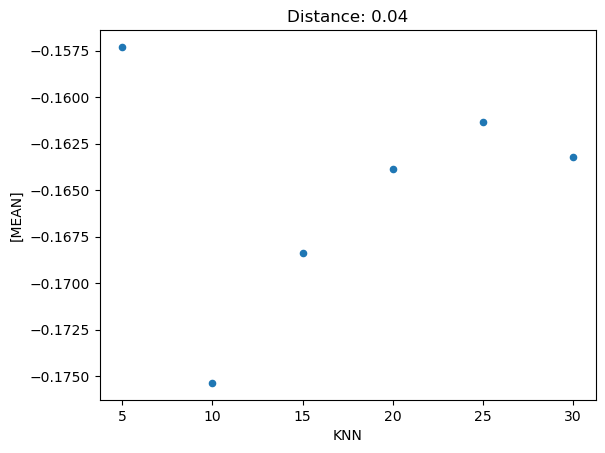

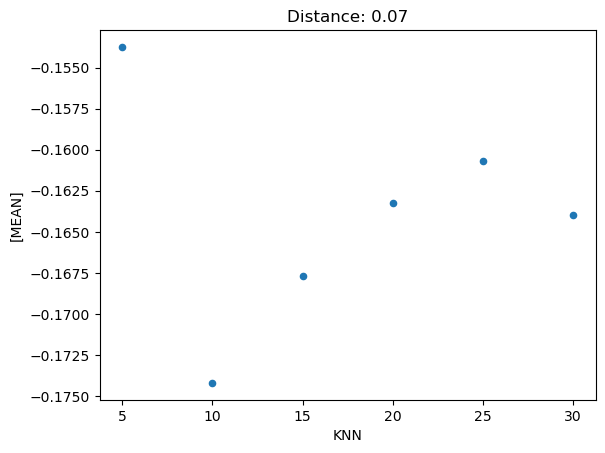

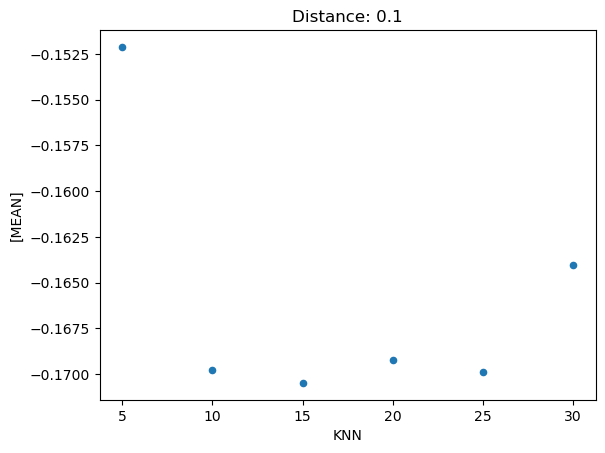

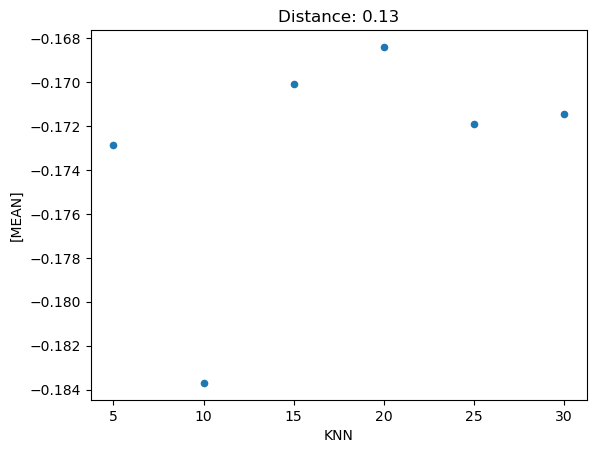

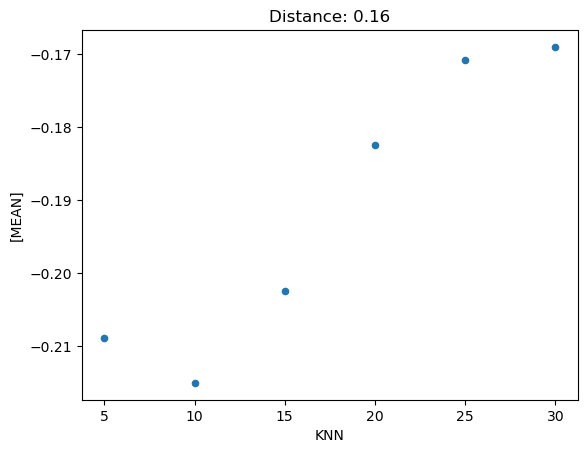

In [38]:
df_data = pd.DataFrame(input_data)

import matplotlib.pyplot as plt

aggl_cluster_distance = [0.04,0.07,0.1,0.13,0.16]
plt.figure(figsize=(10, 5))
for distance in aggl_cluster_distance:
    df_data[df_data['NUMBER_AGGL_DISTANCE']==distance].plot.scatter(x="KNN", y=['MEAN'], title='Distance: '+str(distance))

plt.show()